# Downloading Images with XEE

## Introduction

When using data hosted in Google Earth Engine in Python-based workflows - one of the main pain points is the extraction of large datasets. This typically involves a long running Export process which makes subsequent processing of the results challenging. With the introduction of new [`ee.data.getPixels()`](https://developers.google.com/earth-engine/apidocs/ee-data-getpixels) API from GEE, we can now directly fetch image data as an array. The [XEE](https://github.com/google/Xee) package makes this process seamless and extracts the results as an XArray Dataset. We can then use `rioxarray` to clip and save the extracted XArray DataSet to a GeoTIFF file directly without going through an Export task.

## Overview of the Task

[LandScan Population Data Global 1km](https://gee-community-catalog.org/projects/landscan/) is one of the highest quality global gridded population datasets and is made easily accessible via the Awesome GEE Community Catalog. In this tutorial, we will download the 2021 population grid for Kenya as a GeoTIFF file directly from the cloud-hosted dataset.


**Input Layers**:
* `ne_10m_admin_0_countries_ind.zip`: A shapefile of country boundaries


**Output Layers**:
*   `population.tif` : A GeoTIFF file of gridded population


**Data Credit**:
*   Sims, K., Reith, A., Bright, E., McKee, J., & Rose, A. (2022). LandScan Global 2021. Oak Ridge National Laboratory. https://doi.org/10.
48690/1527702
* Made with Natural Earth. Free vector and raster map data @ naturalearthdata.com.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install xee rioxarray

In [9]:
import datetime
import ee
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rioxarray as rxr
import xarray as xr

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [4]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

shapefile = 'ne_10m_admin_0_countries_ind.zip'

data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'
download('{}/{}'.format(data_url,shapefile))

Downloaded data/ne_10m_admin_0_countries_ind.zip


Initialize EE with the [High-Volume EndPoint](https://developers.google.com/earth-engine/guides/processing_environments#high-volume_endpoint) recommended to be used with XEE. Replace the value of the `cloud_project` variable with your own project id that is linked with GEE.


In [5]:
cloud_project = 'spatialthoughts' # replace with your project id

try:
    ee.Initialize(
        project=cloud_project,
        opt_url='https://earthengine-highvolume.googleapis.com')
except:
    ee.Authenticate()
    ee.Initialize(
        project=cloud_project,
        opt_url='https://earthengine-highvolume.googleapis.com')

## Data Preparation

We read the Natural Earth administrative regions shapefile and select a country.

In [10]:
shapefile_path = os.path.join(data_folder, shapefile)
boundaries_gdf = gpd.read_file(shapefile_path)

Select the country of your choice using the [3-letter ISO code](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) for your country. Here we use `KEN` for Kenya.

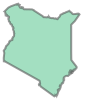

In [12]:
country = boundaries_gdf[boundaries_gdf['ADM0_A3'] == 'KEN']
geometry = country.geometry.union_all()
geometry

Select the year and dataset.

In [14]:
year = 2023
start_date = ee.Date.fromYMD(year, 1, 1)
end_date = ee.Date.fromYMD(year+1, 1, 1)
landscan = ee.ImageCollection('projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL')


Apply the filters and select the image to download using the Earth Engine Python API syntax.


In [16]:
filtered = landscan.filter(ee.Filter.date(start_date, end_date))
image = filtered.first()
print(image.get('system:index').getInfo())

landscan-global-2023


We now open the image. XEE works only with ImageCollections so we convert the clipped image to an ImageCollection. We also construct a bounding box from the country boundary.

In [17]:
image_col = ee.ImageCollection([image])
bbox = ee.Algorithms.GeometryConstructors.BBox(*geometry.bounds)

Now we have an ImageCollection that we want to get it as a XArray Dataset. We extract the ImageCollection using the 'ee' engine provided by XEE. We specify the `crs` and `scale` for the required data. Currently XEE works well with data in `EPSG:4326` and scale in degrees. So we use `0.0083333333333333` (i.e 1km) as the scale.

In [19]:
ds = xarray.open_dataset(
    image_col,
    engine='ee',
    crs='EPSG:4326',
    scale=0.0083333333333333,
    geometry=bbox,
)
ds

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 1, lon: 959, lat: 1165)
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-01-01
  * lon      (lon) float64 8kB 33.89 33.9 33.91 33.92 ... 41.86 41.87 41.88
  * lat      (lat) float64 9kB -4.673 -4.665 -4.657 -4.648 ... 5.01 5.018 5.027
Data variables:
    b1       (time, lon, lat) float32 4MB ...
Attributes:
    crs:      EPSG:4326

The Dataset has only 1 time coordinate (the chosen year) and 1 variable (the band b1). Select it to get a DataArray.

In [20]:
da = ds.isel(time=0).b1
da

<xarray.DataArray 'b1' (lon: 959, lat: 1165)> Size: 4MB
[1117235 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2023-01-01
  * lon      (lon) float64 8kB 33.89 33.9 33.91 33.92 ... 41.86 41.87 41.88
  * lat      (lat) float64 9kB -4.673 -4.665 -4.657 -4.648 ... 5.01 5.018 5.027
Attributes:
    id:             b1
    data_type:      {'type': 'PixelType', 'precision': 'int', 'min': -2147483...
    dimensions:     [43200, 21600]
    crs:            EPSG:4326
    crs_transform:  [0.008333333333, 0, -180, 0, -0.008333333333, 89.99999999...

## Downloading Data

We can now clip and format the dataset to the format expected by `rioxarray`.

In [23]:
# transform the image to suit rioxarray format
da_clipped = da \
  .rename({'lat': 'y', 'lon': 'x'}) \
  .transpose('y', 'x') \
  .rio.write_crs('EPSG:4326') \
  .rio.clip(country.geometry.values)
da_clipped

<xarray.DataArray 'b1' (y: 1165, x: 959)> Size: 4MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time         datetime64[ns] 8B 2023-01-01
  * x            (x) float64 8kB 33.89 33.9 33.91 33.92 ... 41.86 41.87 41.88
  * y            (y) float64 9kB -4.673 -4.665 -4.657 ... 5.01 5.018 5.027
    spatial_ref  int64 8B 0
Attributes:
    id:             b1
    data_type:      {'type': 'PixelType', 'precision': 'int', 'min': -2147483...
    dimensions:     [43200, 21600]
    crs_transform:  [0.008333333333, 0, -180, 0, -0.008333333333, 89.99999999...

We can reproject the results to the desired output CRS.

In [24]:
da_reprojected = da_clipped.rio.reproject('EPSG:3857')
da_reprojected

<xarray.DataArray 'b1' (y: 1166, x: 958)> Size: 4MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 8kB 3.773e+06 3.774e+06 ... 4.661e+06 4.662e+06
  * y            (y) float64 9kB 5.603e+05 5.594e+05 ... -5.203e+05 -5.212e+05
    time         datetime64[ns] 8B 2023-01-01
    spatial_ref  int64 8B 0
Attributes:
    id:             b1
    data_type:      {'type': 'PixelType', 'precision': 'int', 'min': -2147483...
    dimensions:     [43200, 21600]
    crs_transform:  [0.008333333333, 0, -180, 0, -0.008333333333, 89.99999999...
    _FillValue:     nan

Finally we save the results as a GeoTIFF file.

In [26]:
output_file = 'population.tif'
output_path = os.path.join(output_folder, output_file)
da_reprojected.rio.to_raster(output_path, driver='COG')

----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>